# Support-Vector Machines

In this mini-series, I'm going to go through the following three classical classification methods
- **Support-Vector Classifier (SVC)**
- Random Forest Classifier (RFC)
- Multilayer Perceptron (MLP)

and today is the first of the series, support-vector classifier (also called support vector machine).

The main reference is *Fundamentals of Machine Learning* by Thomas P. Trappenberg. I was able to pick up the digital version from the university library. (The version that I got doesn't seem to be the complete version. It's missing some of its elements.) Another great resource is of course Wikipedia.

So what is the SVM method in classification problem? We'll see more pictures later, but basically it's one way to draw a line to distinguish who's who (so are the other two classification methods in this series). How one draws the line will be the specific of the method.

For this to work, we need a sample data that already tells us who's-who, i.e., a labeled data set. This makes SVM a **supervised learning algorithm** in machine learning. Once the SVM algorithm chooses the best line that seperates the clusters geometrically (this is a non-statistical approach), we use the line to classify new samples even though they are not labeled.

Now drawing a line is like a common expression, but in three or higher dimensions, it's really a hyperplane that seperates space. Because we use a hyperplane, it's a linear classifier. There is a version of SVM that uses a hypersurface making non-linear classification possible.

There is also a version called the support-vector clustering algorithm, though I wouldn't demonstrate it in this note.

We will use Fisher's Iris flower data set which is perhaps everyone's very first example on classification in statistics.

Everything that we do here uses the `sklearn` package. The best way to learn about SVM in sklearn is of course to check out the <a href="https://scikit-learn.org/stable/modules/svm.html">official documentation</a>.

In [1]:
# Load the Iris flower data using sklearn.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()
print(type(iris))
iris.keys()

<class 'sklearn.utils.Bunch'>


dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

The loaded iris data is the `Bunch` type defined within `sklearn`, and the actual arrays of data can be called using the corresponding keys.

We'll mainly use the first two arrays, `iris.data` and `iris.target`.

In [2]:
print(iris.data.shape)
print(iris.target.shape)

(150, 4)
(150,)


As you can see, they are made out of 150 sample observations. The `iris.data` contains the four features of each sample,

In [3]:
print(iris.feature_names)
print(iris.data[0])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[5.1 3.5 1.4 0.2]


and the `iris.target` tells you the actual class of the sample, hence a labeled data set.

In [4]:
print(iris.target_names)
print(iris.target[0])

['setosa' 'versicolor' 'virginica']
0


We wish to have a model that, given the feature vector $x$ of a sample, the model predicts its class $y$.

Like the most of the data-scientific methods, we wouldn't use all 150 samples for training the model, though doing such is likely to yield the best fitting model. The reason is simple: We'd like to check if our model predicts well (validation), so we spare some portion of the data for the use of validation check.

Of course it wouldn't do the right validation check if we use the same data for training the model and checking its validation. A trained model is supposed to do its best on the data used in the training, so double-checking on the same data doesn't tell us whether the model is going to perform well on new upcoming samples.

How much of a portion should be kept for the validation check? It's a very intellectual question because the model generally works better if more samples were used in training, but we also know the performance of the model better when more samples are used in validation check.

Avoiding to answer to the golden-ratio of them, we'll simply use 50-50 in this example.

In [5]:
# Pick every other samples starting from the 0'th index.
x_train = iris.data[0:-1:2]
y_train = iris.target[0:-1:2]
# Also pick every other samples starting from the 1'st index.
x_test = iris.data[1:-1:2]
y_test = iris.target[1:-1:2]

print(x_train.shape)
print(x_test.shape)
print(iris.data.shape)

(75, 4)
(74, 4)
(150, 4)


Now the data sets are ready, time for the application.

I wouldn't go through the detailed mathematics here because of the time constraints (though I would go through in detail with a chalk & a board in class). But the main idea and its mathematics can be sufficiently understood if you paid attention during the first month of vector calculus where you learn about the distance between a point and a plane (or a line if it's a 2D example).

If you wish to jump to the code (like the future myself), here's a <a href="#code">wormhole</a>.

## Idea

These 75 training samples with four features are the 75 points in the 4D feature space. We wish to set borderlines (hyperplanes) that help us classify the three distinc clusters. But placing a hyperplane only distinguish two classes at a time (binary classification). Since there are more than two classes to distinguish, we do binary classification multiple times. Thus one might wish to understand the two main ideas:
- How does SVM do the binary classification?
- How do we apply the binary classification multiple times properly?

### Binary Classification in SVM

I wrote a seperate page on this with the basic mathematics behind. Check out my another note on <a href="The_school_mathematics_behind_SVM.html">the math behind SVM</a>.

The story without math is as the following:

If it's possible to place a hyperplane to distinguish the two groups of sample points, SVM places a hyperplane so that the distance from the plane to the closest point of each group is equal and maximized.

If it's not possible to place such hyperplane, SVM applies what's called a soft-margin to its criteria and offers the best approximation of the distinction of two groups.

### Multi-class Classification in `sklearn.svm.SVC`

When there are more than two groups to seperate, there are two classical approaches to apply binary classification multiple times.
- One-versus-All (OVA)
- One-versus-One (OVO)

#### OVA
The OVA will compare each group to the rest of the other groups as a whole. In our example, it's going to be like having all of
- `setosa` vs `versicolor` + `virginica`,
- `versicolor` vs `setosa` + `virginica`,
- `virginica` vs `setosa` + `versicolor`.
In general, if we have $k$ groups, there will be $k$ binary classifiers obtained from the OVA method.

Now given a new sample, we apply all these three classifiers and obtain a score for each. For example, if my iris sample has
- `setosa` vs `versicolor` + `virginica` score 0.8,
- `versicolor` vs `setosa` + `virginica` score 0.5,
- `virginica` vs `setosa` + `versicolor` score -0.1,
then the OVA algorithm chooses `setosa` as the predicted class of my sample. This is also called the winner-takes-all strategy in some literatures.

The downside of this approach is that each binary classification used in the method has a significant imbalance of sample sizes between two groups of comparison, leading to a possible distorsion of the reality.

#### OVO

The OVO solves the inherent problem of the OVA approach by comparing groups individually at the cost of performing binary classification more times.

If there are $k$ groups in the labeled data, we have to make ${k\choose2} = \frac{k (k-1)}{2}$ comparisons. In our example, we have
- `setosa` vs `versicolor`,
- `setosa` vs `virginica`,
- `virginica` vs `versicolor`

which happens to require the same amount of binary classifications performed as the OVA case becase we have the magic number $k = 3$ solving
$$k = \frac{k(k-1)}{2}.$$
But for $k > 3$, surely OVO is more expensive.

In `sklearn.svm.SVC`, the default method is OVO. There is also an option to support the OVA approach, according to the <a hre="https://scikit-learn.org/stable/modules/svm.html">official document</a>.

<a name="code"></a>
## `sklearn.svm.SVC`

Here's how to communicate with `sklearn.svm`.
- We're going to declare that our model is `svm.SVC`. We have to declare this explicitly because there are other options like `svm.LinearSVC` are available.
```python
model = svm.SVC(kernel = 'linear')
```
    - Upon declaring the `svm.SVC` model, declare the kernel which is `linear` in our case. This can be changed if you choose to use non-linear SVM.
- All the mathematical algorithms discussed earlier are performed in a single line
```python
model.fit(x_train, y_train)
```
(This is why the educators try to convince students that "*You need to know what you are doing*" whereas the students keep saying "*Why do I need to understand the math when the computer does all the computations for me?*")
- Once the model is trained based on the training data, we try to make a prediction of the test data.
```python
y_predicted = model.predict(x_test)
```

In [6]:
# SVC from sklearn.svm
from sklearn import svm

# model
model = svm.SVC(kernel = 'linear')
# train
model.fit(x_train, y_train)
# prediction
y_predicted = model.predict(x_test)
# evluation
print('Percentage correct accuracy of SVM: ', np.mean(y_test == y_predicted))

Percentage correct accuracy of SVM:  0.972972972972973


There are many types of performance measures and evaluations.
- TP: True Positivie
- FP: Fals Positive
- TN: True Negative
- FN: False Negative

\begin{align*}
\text{Accuracy } &= \frac{TP + TN}{TP + TN + FP + FN} \\
\text{True Positive Rate } &= \frac{TP}{TP + FN} \\
\text{False Positive Rate } &= \frac{FP}{FP + TN} \\
\text{Precision } &= \frac{TP}{TP + FP} \\
\text{Recall } &= \frac{TP}{TP + FN} \\
F_1 &= 2 \cdot \frac{precision \cdot recall}{precision + recall}
\end{align*}

In [7]:
# performance measures and evaluations

from sklearn import metrics

print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.96      0.96      0.96        25
           2       0.96      0.96      0.96        24

    accuracy                           0.97        74
   macro avg       0.97      0.97      0.97        74
weighted avg       0.97      0.97      0.97        74



There is no simple best measure of performance. You have to choose your standard depending on the data.

We can also color-code the performance using the confusion matrix.

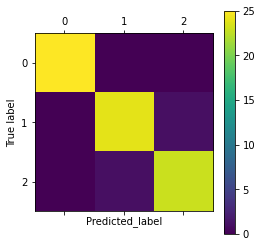

In [8]:
# confusion matrix
matrix = metrics.confusion_matrix(y_test, y_predicted)
plt.matshow(matrix)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted_label')
plt.show()

These measurements can also be simply improved by overfitting, thereby loosing the value of the model.

There's another way to improve the validity of the model using the **$k$-fold cross-validation** which we will discuss later <a href="#">later</a>.

This page is getting too long, so we'll discuss the **non-linear SVM** in <a href="#">another time</a>.